In [6]:
# automatically reload the package when it is modified
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test Multiagent Simulation    

In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
# set tf to cpu only
tf.config.set_visible_devices([], 'GPU')

import jax
jax.config.update('jax_platform_name', 'cpu')

from jax import numpy as jnp
import numpy as np
import mediapy
from tqdm import tqdm
import dataclasses
import random
import torch

import waymax
from waymax import config as _config
from waymax import dataloader
from waymax import datatypes
# from waymax import dynamics
from waymax import env as _env
from waymax import agents
from waymax import visualization
from rl_env.env_utils import inverse_unicycle_control, smooth_scenario
from waymax.agents import actor_core
from rl_env.waymax_env import MultiAgentEnvironment
from rl_env.waymax_util import WomdLoader
from rl_env.sim_agent_actor import SimAgentMTR
from rl_env.unicycle_model import InvertibleUnicycleModel

from mtr.config import cfg, cfg_from_yaml_file
max_num_objects = 128

# # create a dataset
# WOMD_1_2_0_VAL_LOCAL = _config.DatasetConfig(
#     # path='/Data/Dataset/Waymo/V1_2_tf/validation_interactive/validation_interactive_tfexample.tfrecord@150',
#     path='/Data/Dataset/Waymo/V1_2_tf/validation/validation_tfexample.tfrecord@150',
#     # path='/Data/Dataset/Waymo/V1_2_tf/training/training_tfexample.tfrecord@1000',
#     max_num_rg_points=30000,
#     data_format=_config.DataFormat.TFRECORD,
#     max_num_objects=max_num_objects,
#     shuffle_seed = 99,
# )

# data_iter = WomdLoader(data_config=WOMD_1_2_0_VAL_LOCAL)

from bc.dataset import WaymaxDataset
data_root = '/Data/Dataset/Waymo/V1_2_tf/validation_interactive_extracted'
dataset = WaymaxDataset(data_root)

Total number of scenarios:  43479


Loading scenario idx  43476


""

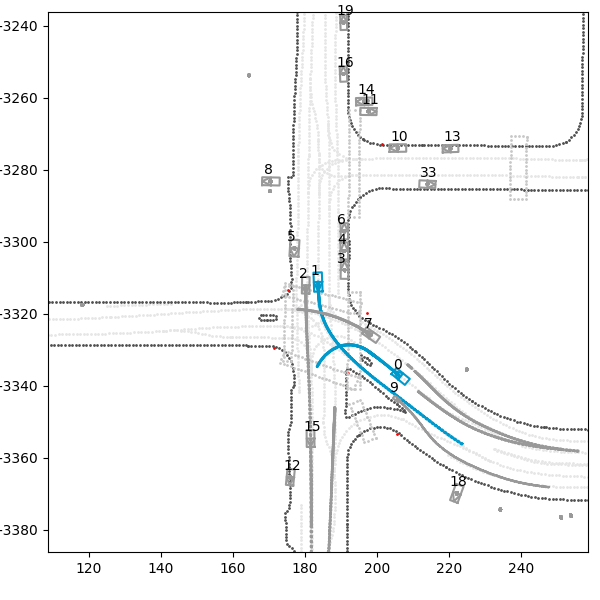

(Array([0, 1], dtype=int32),)
fffa4fac8050d2db


In [42]:
scenario_id, scenario = dataset.load_scenario_by_id('fffa4fac8050d2db')                
# scenario_id, scenario = dataset.load_scenario(1)
scenario: datatypes.SimulatorState = smooth_scenario(scenario)

img = visualization.plot_simulator_state(scenario, use_log_traj=True, highlight_obj = _config.ObjectType.MODELED)
mediapy.show_image(img)
print(jnp.where(scenario.object_metadata.is_modeled))
print(scenario_id)

In [ ]:
# scenario_id, scenario = data_iter.next()
# scenario: datatypes.SimulatorState = smooth_scenario(scenario)
# img = visualization.plot_simulator_state(scenario, use_log_traj=True, highlight_obj = _config.ObjectType.MODELED)
# mediapy.show_image(img)
# print(jnp.where(scenario.object_metadata.is_modeled))

# Define Environment

In [97]:
# Import model
from mtr.models.context_encoder.mtr_encoder import MTREncoder

from mtr.models.motion_decoder.bc_decoder import BCDecoder
dynamics_model = InvertibleUnicycleModel(max_accel=8, max_steering=0.8)
# 30k #755k
path = 'output/bc_bicycle_4_freeze/epoch=0-step=755000.ckpt'
cfg_path = 'tools/cfgs/waymo/bc_atten_ctrl.yaml'

# from mtr.models.motion_decoder.bc_decoder_discrete import BCDecoder
# dynamics_model = InvertibleUnicycleModel(max_accel=8, max_steering=0.8)
# path = 'output/bc_discrete_4_freeze/epoch=0-step=690000.ckpt'
# cfg_path = 'tools/cfgs/waymo/bc_atten_discrete.yaml'

# from mtr.models.motion_decoder.bc_decoder_delta import BCDecoder
# dynamics_model = waymax.dynamics.DeltaLocal()
# path = 'output/bc_atten_4_unfreeze_state/epoch=19-step=1211340.ckpt'
# cfg_path = 'tools/cfgs/waymo/rl_finetune.yaml'

cfg = cfg_from_yaml_file(cfg_path, cfg)
import matplotlib.pyplot as plt

In [98]:
# Config the multi-agent environment:
init_steps = 11

# Set the dynamics model the environment is using.
# Note each actor interacting with the environment needs to provide action
# compatible with this dynamics model.

# Expect users to control all valid object in the scene.
env = MultiAgentEnvironment(
    dynamics_model=dynamics_model,
    config=dataclasses.replace(
        _config.EnvironmentConfig(),
        init_steps = init_steps,
        max_num_objects=max_num_objects,
        controlled_object=_config.ObjectType.MODELED,
        rewards = _config.LinearCombinationRewardConfig(
            rewards={
                'overlap': 1.0, # Positive is good.  
                'offroad': 1.0, # Negative is good.
                'kinematics': 1.0, # Negative is good.
            }
        )
    ),
)

# Define Control Policy

In [99]:
@jax.jit
def check_controlled(state: datatypes.SimulatorState):
    # is_valid = jnp.logical_or(state.object_metadata.is_modeled, state.object_metadata.is_sdc)
    is_valid = state.sim_trajectory.valid[..., state.timestep]
    
    # get velocity in the log
    v_x_log = state.log_trajectory.vel_x[:,:11] # [num_agents, num_steps]
    v_y_log = state.log_trajectory.vel_y[:,:11] # [num_agents, num_steps]
    valid_log = state.log_trajectory.valid[:, :11]
    v_x_log = jnp.where(valid_log, v_x_log, 0)
    v_y_log = jnp.where(valid_log, v_y_log, 0)
    v_log = jnp.linalg.norm(jnp.stack([v_x_log, v_y_log], axis=-1), axis=-1)
    v_max = jnp.max(v_log, axis=-1)
    is_moving = v_max > 0.1
    
    is_vehicle = (state.object_metadata.object_types == 1)
    
    return jnp.logical_and(is_valid, jnp.logical_and(is_moving, is_vehicle))

# @jax.jit
# def check_controlled(state: datatypes.SimulatorState):
#     return state.object_metadata.is_modeled

In [100]:
# Setup a few actors, see visualization below for how each actor behaves.
# An actor that doesn't move, controlling all objects with index > 4
encoder = MTREncoder(cfg.MODEL.CONTEXT_ENCODER)
decoder = BCDecoder(encoder.num_out_channels, cfg.MODEL.MOTION_DECODER)
# load model
state_dict = torch.load(path)['state_dict']

encoder.load_model(state_dict)
decoder.load_model(state_dict)

actor_policy = SimAgentMTR(
    context_encoder= encoder,
    motion_decoder= decoder,
    is_controlled_func = check_controlled,
)

actor_policy.eval()
actor_policy.to('cuda')

# Simulate

Loading scenario idx  43368


""

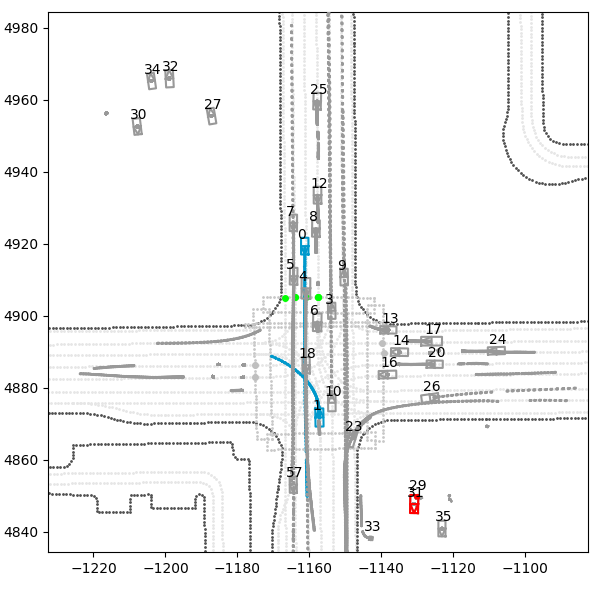

(Array([0, 1], dtype=int32),)
ff5b5a12cfa06f20


In [114]:
# ffd920fc681f7be Good example

scenario_id, scenario = dataset.load_scenario_by_id('ff5b5a12cfa06f20')                
# scenario_id, scenario = dataset.load_scenario(1)
scenario: datatypes.SimulatorState = smooth_scenario(scenario)

img = visualization.plot_simulator_state(scenario, use_log_traj=True, highlight_obj = _config.ObjectType.MODELED)
mediapy.show_image(img)
print(jnp.where(scenario.object_metadata.is_modeled))
print(scenario_id)

In [115]:
# get a scenario from the dataset
# scenario : datatypes.SimulatorState = next(data_iter)
n_agent = scenario.object_metadata.num_objects
# a = np.zeros((n_agent, 91, 2))
states = [env.reset(scenario)]
for i in range(states[0].remaining_timesteps):
  current_state = states[-1]
  policy_output = actor_policy.select_action({}, current_state, None, None)
  # a[:, i, :] = policy_output.action.data
  next_state = env.step_sim_agent(states[-1], [policy_output])
  states.append(next_state)

idx =jnp.where(policy_output.is_controlled)[0]
print("Sim Agent Ids:", jnp.where(policy_output.is_controlled))

Sim Agent Ids: (Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 17, 18, 20, 21,
       23, 24, 25, 26, 28], dtype=int32),)


In [116]:
imgs = []
for state in states:
  imgs.append(visualization.plot_simulator_state(state, use_log_traj=False, highlight_obj = _config.ObjectType.MODELED))
mediapy.show_video(imgs, fps=10)